# Performance analysis

## Stock list

In [1]:
# All changable variables
stock_list_df_path = "data/stock_list.xlsx"
rf = 0.04 / 252  # For sharp ratio calculation
beta = 1  # For Treynor ratio calculation
portfolio_start_size = 1000800  # Portfolio size

# yfinance download date
start_date = "2025-01-31"
end_date = "2025-04-19"

In [2]:
import pandas as pd

stock_list = pd.read_excel("data/stock_list.xlsx", index_col=0)
stock_list[["Industry", "Weight", "Target Weight", "Shares", "Transaction Cost"]]

,Industry,Weight,Target Weight,Shares,Transaction Cost
Company,,,,,
Apple,Information technology,0.040795,0.0409,173.0,81.65600
Amgen,Biopharmaceutical,0.000000,0.0000,0.0,0.00000
Amazon,Retailing,0.000000,0.0000,0.0,0.00000
American Express,Financial services,0.041870,0.0418,132.0,83.80680
Boeing,Aerospace and defense,0.022224,0.0223,126.0,44.48304
Caterpillar,Construction and mining,0.089817,0.0902,242.0,179.77696
Salesforce,Information technology,0.000000,0.0000,0.0,0.00000
Cisco,Information technology,0.000000,0.0000,0.0,0.00000
Chevron,Petroleum industry,0.099877,0.1000,670.0,199.91460


### Stock allocations

- No short selling allowed
- Maximum 10% of portfolio in a single stock

<Axes: ylabel='Weight'>

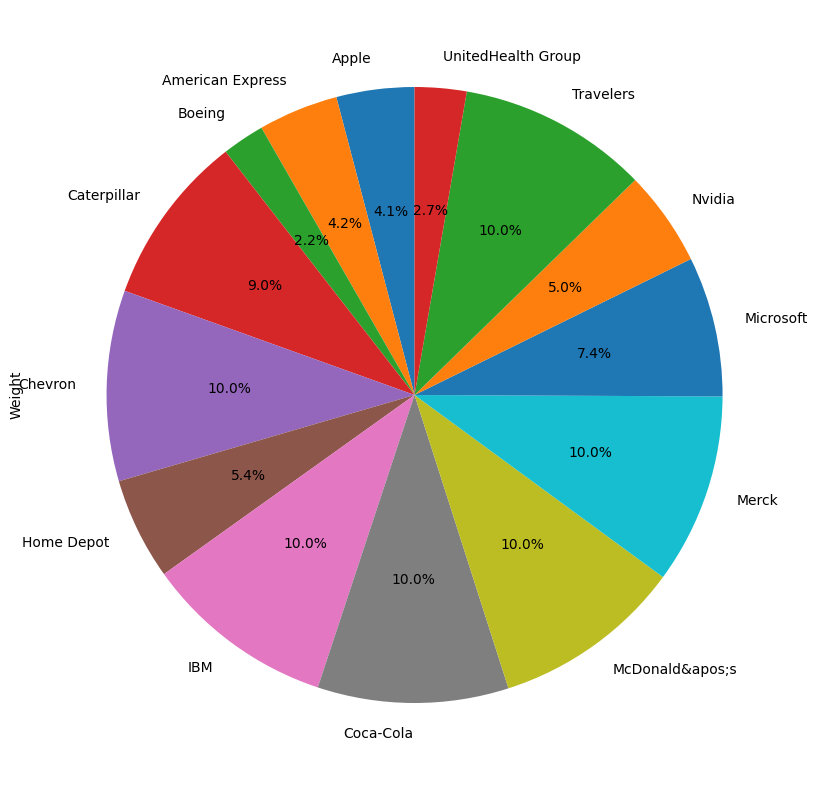

In [3]:
# weights of the portfolio - pie chart
weights = stock_list[stock_list['Weight'] > 0]["Weight"].drop("13 WEEK TREASURY BILL")
weights.plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10), startangle=90, legend=False)

### Industry allocations

<Axes: ylabel='Weight'>

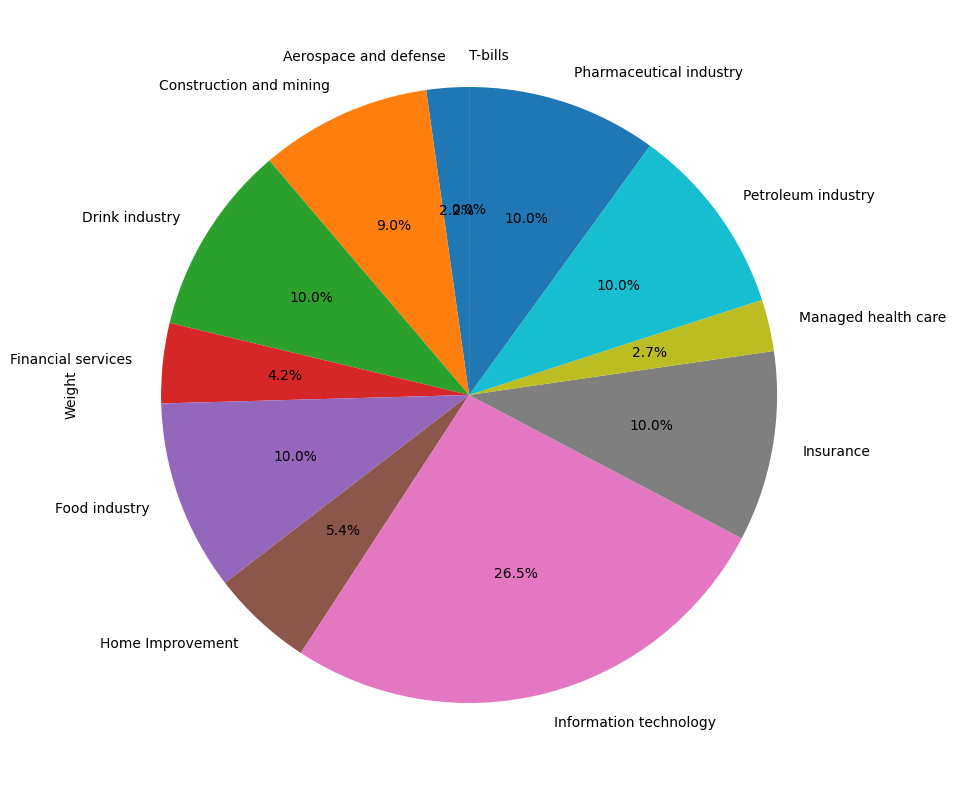

In [4]:
# weights on industry level - bar chart
industry_weights = stock_list.groupby('Industry')['Weight'].sum()
zero_weights = industry_weights[industry_weights == 0]
industry_weights = industry_weights[industry_weights > 0]
industry_weights.plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10), startangle=90, legend=False)

Zero allocation to the following industries:

In [5]:
zero_weights

Industry
Biopharmaceutical                 0.0
Broadcasting and entertainment    0.0
Clothing industry                 0.0
Conglomerate                      0.0
Fast-moving consumer goods        0.0
Retailing                         0.0
Speciality chemicals              0.0
Telecommunications industry       0.0
Name: Weight, dtype: float64

## Performance metrics

### Download daily price data (Close)

- stock price
- DJIA index

In [6]:
import yfinance as yf

# download stock data
stock_data = yf.download(tickers=stock_list["Symbol"].tolist(), start=start_date, end=end_date)  # type: ignore
# print out level 1 column names
stock_data: pd.DataFrame = stock_data["Close"]  # type: ignore
# Adjuste t-bill to accumulate
stock_data["^IRX"] = stock_data["^IRX"] / 252 / 100
stock_data["^IRX"] = (stock_data["^IRX"] + 1).cumprod()
# Show first and last day of the data
stock_data.iloc[[0, -1], :].T.tail(3)  # type: ignore

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  31 of 31 completed


Date,2025-01-31,2025-04-17
Ticker,,
VZ,38.767326,44.040001
WMT,97.891182,93.220001
^IRX,1.000166,1.009034


In [7]:
# DJIA index
djia = yf.download('^DJI', start=start_date, end=end_date)  # type: ignore
djia: pd.DataFrame = djia['Close']  # type: ignore
djia.iloc[[0, -1], :].T  # type: ignore


[*********************100%***********************]  1 of 1 completed


Date,2025-01-31,2025-04-17
Ticker,,
^DJI,44544.660156,39142.230469


### Accumulated returns

Text(1, -11.628119663613578, '-12.13%')

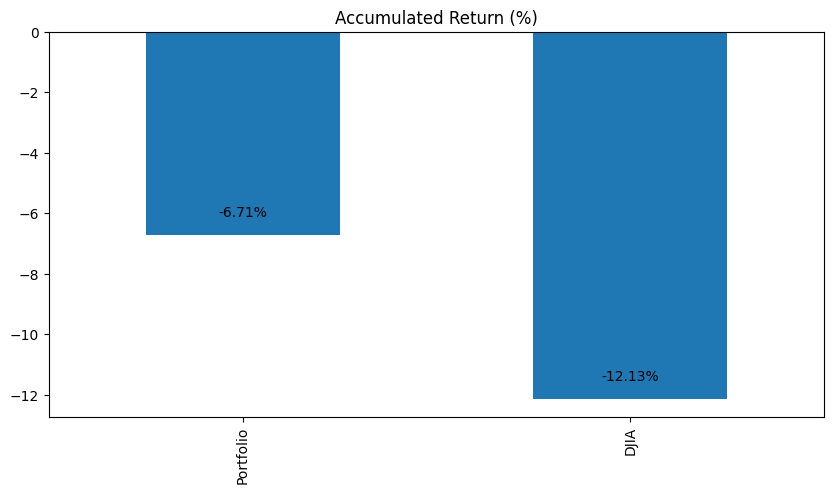

In [8]:
stock_returns = (stock_data.iloc[-1] / stock_data.iloc[0] - 1)
djia_return = (djia.iloc[-1] / djia.iloc[0] - 1)
portfolio_return = (stock_returns * stock_list["Weight"].values).sum()

# show percentage on the plot

accumulated_return = pd.Series({
    "Portfolio": portfolio_return * 100,
    "DJIA": djia_return.values[0] * 100,
}, name="Accumulated Return (%)")

accumulated_return.plot(kind='bar', figsize=(10, 5), title="Accumulated Return (%)")
# show percentage on the plot
import matplotlib.pyplot as plt
plt.text(0, portfolio_return * 100 + 0.5, f"{portfolio_return * 100:.2f}%", ha='center', va='bottom')
plt.text(1, djia_return.values[0] * 100 + 0.5, f"{djia_return.values[0] * 100:.2f}%", ha='center', va='bottom')

Time series plot of accumulated returns

<Axes: title={'center': 'Accumulated Return (%)'}, xlabel='Date'>

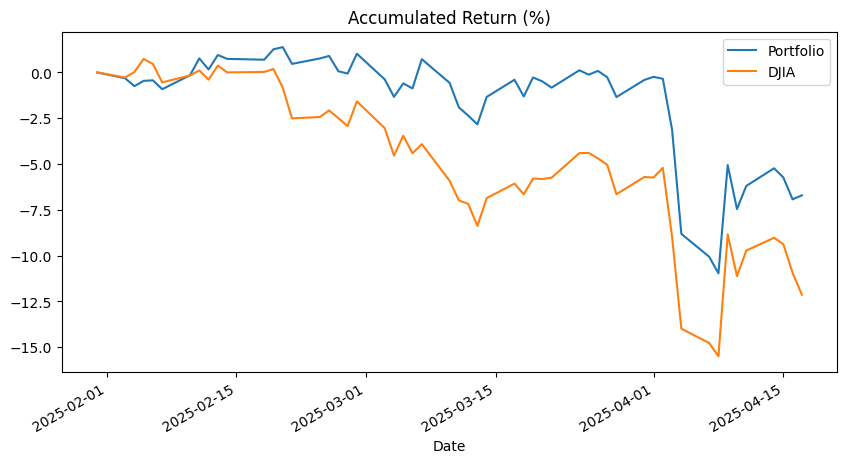

In [9]:
djia_accumulated = djia / djia.iloc[0] - 1
portfolio_accumulated_returns = (stock_data / stock_data.iloc[0] - 1).dot(stock_list["Weight"].values)

# plot accumulated returns
accumulated = pd.concat([portfolio_accumulated_returns * 100, djia_accumulated * 100], axis=1)
accumulated.columns = ["Portfolio", "DJIA"]
accumulated.plot(figsize=(10, 5), title="Accumulated Return (%)", legend=True)

### T test for excess returns

Excess returns (log daily returns) = portfolio returns - DJIA index returns 

In [10]:
import numpy as np
djia_log_returns: pd.DataFrame = np.log(djia / djia.shift(1)).dropna()  # type: ignore
portfolio_log_returns: pd.Series = np.log((portfolio_accumulated_returns + 1) / (portfolio_accumulated_returns + 1).shift(1)).dropna()  # type: ignore

log_returns = pd.concat([portfolio_log_returns, djia_log_returns], axis=1)
log_returns.columns = ["Portfolio", "DJIA"]
log_returns["Excess"] = log_returns["Portfolio"] - log_returns["DJIA"]
log_returns.describe()

,Portfolio,DJIA,Excess
count,53.000000,53.000000,53.000000
mean,-0.001310,-0.002439,0.001130
std,0.015449,0.017203,0.005368
min,-0.060533,-0.056598,-0.011496
25%,-0.008293,-0.009990,-0.002503
50%,-0.002081,-0.002759,0.000143
75%,0.007383,0.005215,0.004719
max,0.064264,0.075760,0.015762


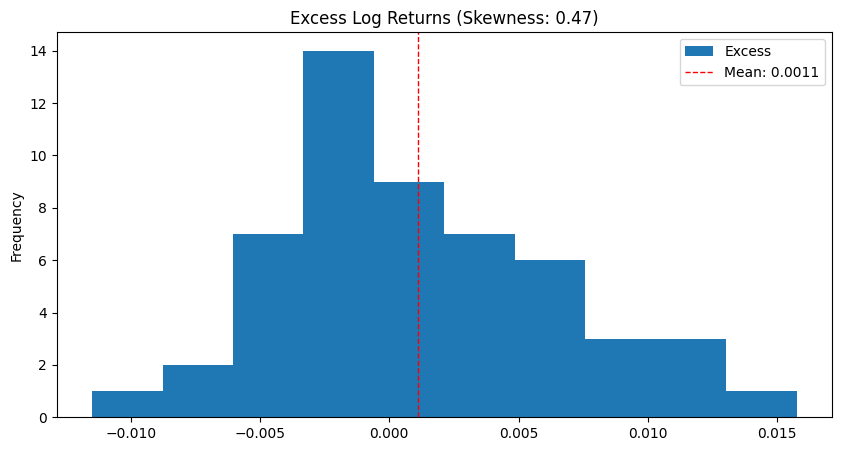

In [11]:
# Skewness
from scipy.stats import skew
skewness = skew(log_returns["Excess"])
mean_excess_returns = log_returns["Excess"].mean()
log_returns["Excess"].plot(kind='hist', figsize=(10, 5), title=f"Excess Log Returns (Skewness: {skewness:.2f})")
# add vertical line for mean
plt.axvline(mean_excess_returns, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_excess_returns:.4f}')
plt.legend()


 t test for excess returns
- Null hypothesis: excess returns = 0
- Alternative hypothesis: excess returns > 0

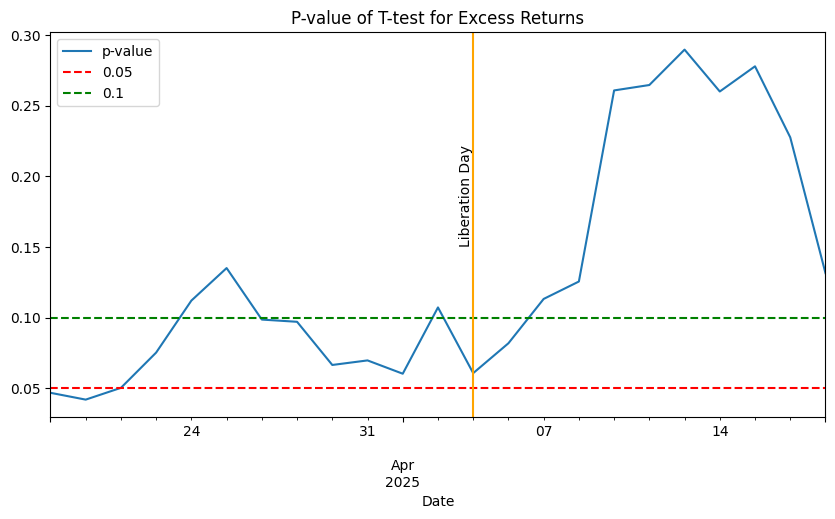

In [12]:
# t test for excess returns
from scipy import stats

t_test_results = pd.DataFrame(columns=["T-statistic", "P-value"], index=log_returns.index[30:])

for end_date in log_returns.index[30:]:
    t_stat, p_value = stats.ttest_1samp(log_returns["Excess"][:end_date], 0)
    t_test_results.loc[end_date] = [t_stat, p_value]
    
t_test_results = t_test_results.astype(float)
t_test_results["P-value"].plot(kind='line', figsize=(10, 5), title="P-value of T-test for Excess Returns")
plt.axhline(y=0.05, color='r', linestyle='--')
plt.axhline(y=0.1, color='g', linestyle='--')
# add tariffs day 2025-04-03 vertical line
plt.axvline(x=pd.to_datetime("2025-04-03"), color='orange', linestyle='-')  # type: ignore
plt.text(pd.to_datetime("2025-04-03"), 0.15, "Liberation Day", rotation=90, verticalalignment='bottom', horizontalalignment='right')  # type: ignore
plt.legend(["p-value", "0.05", "0.1"])

In [13]:
# Tariffs period t test
t_stat, p_value = stats.ttest_1samp(log_returns["Excess"]["2025-04-03":], 0)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 0.38485918892750215, P-value: 0.7084002292288846


In [14]:
# Excess returns pre and post tariffs and total
mean_excess_returns = pd.DataFrame(columns=["Pre-Tariffs", "Post-Tariffs", "Total"], index=["Mean", "Std", "T-statistic", "P-value"])
mean_excess_returns.loc["Mean"] = [
    log_returns["Excess"][:"2025-04-03"].mean(),
    log_returns["Excess"]["2025-04-03":].mean(),
    log_returns["Excess"].mean()
]
mean_excess_returns.loc["Std"] = [
    log_returns["Excess"][:"2025-04-03"].std(),
    log_returns["Excess"]["2025-04-03":].std(),
    log_returns["Excess"].std()
]
mean_excess_returns.loc["T-statistic"] = [
    stats.ttest_1samp(log_returns["Excess"][:"2025-04-03"], 0)[0],
    stats.ttest_1samp(log_returns["Excess"]["2025-04-03":], 0)[0],
    stats.ttest_1samp(log_returns["Excess"], 0)[0]
]
mean_excess_returns.loc["P-value"] = [
    stats.ttest_1samp(log_returns["Excess"][:"2025-04-03"], 0)[1],
    stats.ttest_1samp(log_returns["Excess"]["2025-04-03":], 0)[1],
    stats.ttest_1samp(log_returns["Excess"], 0)[1]
]
mean_excess_returns = mean_excess_returns.astype(float)
mean_excess_returns


,Pre-Tariffs,Post-Tariffs,Total
Mean,0.001450,0.000897,0.001130
Std,0.004931,0.007728,0.005368
T-statistic,1.927907,0.384859,1.532468
P-value,0.060646,0.708400,0.131469


## Ratios

- Sharpe ratio
- Sortino ratio
- Calmar ratio
- Treynor ratio
- Max drawdown

In [15]:
def sharpe(returns: pd.Series, risk_free_rate: float = 0.0) -> float:
    """
    Calculate the Sharpe ratio of a portfolio.
    
    :param returns: A pandas Series of portfolio returns.
    :param risk_free_rate: The risk-free rate (default is 0.0).
    :return: The Sharpe ratio.
    """
    excess_returns = returns - risk_free_rate
    return excess_returns.mean() / excess_returns.std()

def sortino(returns: pd.Series, target: float = 0.0) -> float:
    """
    Calculate the Sortino ratio of a portfolio.
    
    :param returns: A pandas Series of portfolio returns.
    :param target: The target return (default is 0.0).
    :return: The Sortino ratio.
    """
    downside_returns = returns[returns < target]
    return (returns.mean() - target) / downside_returns.std() if not downside_returns.empty else np.nan

def max_drawdown(returns: pd.Series) -> float:
    """
    Calculate the maximum drawdown of a portfolio.
    
    :param returns: A pandas Series of portfolio returns.
    :return: The maximum drawdown.
    """
    # log returns
    cumulative_returns = returns.cumsum().apply(np.exp)
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def calmar(returns: pd.Series) -> float:
    """
    Calculate the Calmar ratio of a portfolio.
    
    :param returns: A pandas Series of portfolio returns.
    :return: The Calmar ratio.
    """
    return returns.mean() / abs(max_drawdown(returns)) if max_drawdown(returns) != 0 else np.nan

def omega(returns: pd.Series, target: float = 0.0) -> float:
    """
    Calculate the Omega ratio of a portfolio.
    
    :param returns: A pandas Series of portfolio returns.
    :param target: The target return (default is 0.0).
    :return: The Omega ratio.
    """
    gain = returns[returns > target].sum()
    loss = abs(returns[returns < target].sum())
    return gain / loss if loss != 0 else np.nan

def treynor(returns: pd.Series, beta: float) -> float:
    """
    Calculate the Treynor ratio of a portfolio.
    
    :param returns: A pandas Series of portfolio returns.
    :param beta: The beta of the portfolio.
    :return: The Treynor ratio.
    """
    return (returns.mean() - 0.0) / beta if beta != 0 else np.nan

def information(returns: pd.Series, benchmark: pd.Series) -> float:
    """
    Calculate the Information ratio of a portfolio.
    
    :param returns: A pandas Series of portfolio returns.
    :param benchmark: A pandas Series of benchmark returns.
    :return: The Information ratio.
    """
    active_return = returns - benchmark
    return active_return.mean() / active_return.std() if active_return.std() != 0 else np.nan


In [16]:
# Calculate the performance metrics for pre-tariffs post-tariffs and total
performance_matrics = pd.DataFrame(columns=["pre-tariffs", 
                                         "post-tariffs", 
                                         "total", 
                                         "DJIA-pre-tariffs",
                                         "DJIA-post-tariffs",
                                         "DJIA-total"
                                         ], 
                                         index=["Mean", "std", "Sharpe", "Sortino", "Max Drawdown", "Calmar", "Omega", "Treynor", "Information"])
performance_matrics.loc["Mean"] = [
    log_returns["Portfolio"][:"2025-04-03"].mean(),
    log_returns["Portfolio"]["2025-04-03":].mean(),
    log_returns["Portfolio"].mean(),
    log_returns["DJIA"][:"2025-04-03"].mean(),
    log_returns["DJIA"]["2025-04-03":].mean(),
    log_returns["DJIA"].mean()
]

performance_matrics.loc["std"] = [
    log_returns["Portfolio"][:"2025-04-03"].std(),
    log_returns["Portfolio"]["2025-04-03":].std(),
    log_returns["Portfolio"].std(),
    log_returns["DJIA"][:"2025-04-03"].std(),
    log_returns["DJIA"]["2025-04-03":].std(),
    log_returns["DJIA"].std()
]

performance_matrics.loc["Sharpe"] = [
    sharpe(log_returns["Portfolio"][:"2025-04-03"], rf),
    sharpe(log_returns["Portfolio"]["2025-04-03":], rf),
    sharpe(log_returns["Portfolio"], rf),
    sharpe(log_returns["DJIA"][:"2025-04-03"], rf),
    sharpe(log_returns["DJIA"]["2025-04-03":], rf),
    sharpe(log_returns["DJIA"], rf)

]
performance_matrics.loc["Sortino"] = [
    sortino(log_returns["Portfolio"][:"2025-04-03"]),
    sortino(log_returns["Portfolio"]["2025-04-03":]),
    sortino(log_returns["Portfolio"]),
    sortino(log_returns["DJIA"][:"2025-04-03"]),
    sortino(log_returns["DJIA"]["2025-04-03":]),
    sortino(log_returns["DJIA"])
]
performance_matrics.loc["Max Drawdown"] = [
    max_drawdown(log_returns["Portfolio"][:"2025-04-03"]),
    max_drawdown(log_returns["Portfolio"]["2025-04-03":]),
    max_drawdown(log_returns["Portfolio"]),
    max_drawdown(log_returns["DJIA"][:"2025-04-03"]),
    max_drawdown(log_returns["DJIA"]["2025-04-03":]),
    max_drawdown(log_returns["DJIA"])
]
performance_matrics.loc["Calmar"] = [
    calmar(log_returns["Portfolio"][:"2025-04-03"]),
    calmar(log_returns["Portfolio"]["2025-04-03":]),
    calmar(log_returns["Portfolio"]),
    calmar(log_returns["DJIA"][:"2025-04-03"]),
    calmar(log_returns["DJIA"]["2025-04-03":]),
    calmar(log_returns["DJIA"])
]
performance_matrics.loc["Omega"] = [
    omega(log_returns["Portfolio"][:"2025-04-03"]),
    omega(log_returns["Portfolio"]["2025-04-03":]),
    omega(log_returns["Portfolio"]),
    omega(log_returns["DJIA"][:"2025-04-03"]),
    omega(log_returns["DJIA"]["2025-04-03":]),
    omega(log_returns["DJIA"])
]
performance_matrics.loc["Treynor"] = [
    treynor(log_returns["Portfolio"][:"2025-04-03"], beta),
    treynor(log_returns["Portfolio"]["2025-04-03":], beta),
    treynor(log_returns["Portfolio"], beta),
    treynor(log_returns["DJIA"][:"2025-04-03"], beta),
    treynor(log_returns["DJIA"]["2025-04-03":], beta),
    treynor(log_returns["DJIA"], beta)
]
performance_matrics.loc["Information"] = [
    information(log_returns["Portfolio"][:"2025-04-03"], log_returns["DJIA"][:"2025-04-03"]),
    information(log_returns["Portfolio"]["2025-04-03":], log_returns["DJIA"]["2025-04-03":]),
    information(log_returns["Portfolio"], log_returns["DJIA"]),
    information(log_returns["DJIA"][:"2025-04-03"], log_returns["DJIA"][:"2025-04-03"]),
    information(log_returns["DJIA"]["2025-04-03":], log_returns["DJIA"]["2025-04-03":]),
    information(log_returns["DJIA"], log_returns["DJIA"])
]
performance_matrics = performance_matrics.astype(float)
performance_matrics = performance_matrics[["pre-tariffs", "DJIA-pre-tariffs", "post-tariffs", "DJIA-post-tariffs", "total", "DJIA-total"]]
performance_matrics


,pre-tariffs,DJIA-pre-tariffs,post-tariffs,DJIA-post-tariffs,total,DJIA-total
Mean,-0.000738,-0.002187,-0.005996,-0.006893,-0.001310,-0.002439
std,0.008798,0.010867,0.031034,0.034152,0.015449,0.017203
Sharpe,-0.101900,-0.215897,-0.198311,-0.206471,-0.095038,-0.151032
Sortino,-0.119888,-0.241414,-0.319739,-0.378167,-0.112077,-0.202041
Max Drawdown,-0.044441,-0.096435,-0.080941,-0.071532,-0.121784,-0.161069
Calmar,-0.016601,-0.022682,-0.074076,-0.096356,-0.010753,-0.015145
Omega,0.804999,0.571863,0.578240,0.566316,0.761324,0.634698
Treynor,-0.000738,-0.002187,-0.005996,-0.006893,-0.001310,-0.002439
Information,0.294003,NaN,0.116039,NaN,0.210501,NaN


In [17]:
# Save DJIA and portfolio data to csv
portfolio = (portfolio_accumulated_returns + 1) * portfolio_start_size
portfolio = portfolio.round(4)

output = pd.concat([portfolio, djia], axis=1)
output.columns = ["Portfolio", "DJIA"]
output.to_csv("data/portfolio_result.csv", index=True)

pd.set_option('display.float_format', '{:.4f}'.format)
output.head()

,Portfolio,DJIA
Date,,
2025-01-31,1000800.0000,44544.6602
2025-02-03,997610.2690,44421.9102
2025-02-04,993326.4955,44556.0391
2025-02-05,996229.6642,44873.2812
2025-02-06,996477.4742,44747.6289
